# Measurement Procedure

This notebook creates plots that demonstrate the procedure used to measure spectral properties.

In [1]:
import sys
sys.path.insert(0, '..')


In [2]:
from pathlib import Path

import extinction
import numpy as np
import pandas as pd
import sfdmap
import yaml
from astropy import modeling
from matplotlib import pyplot as plt
from scipy.ndimage.filters import median_filter
from scipy.optimize import curve_fit
from scipy.stats import norm
from sndata.sdss import Sako18Spec

from spec_analysis.features import ObservedFeature


## Loading Project Data


In [3]:
_project_root = Path('.').resolve().parent
_dust_dir = _project_root / 'spec_analysis' / 'schlegel98_dust_map'
_results_dir = _project_root / 'results'


In [4]:
s18 = Sako18Spec()
s18.download_module_data()

# Load the dustmap used during the analysis
DUST_MAP = sfdmap.SFDMap(_dust_dir)

# Load feature measurements
PIPELINE_DATA = pd.read_csv(_results_dir / 'final_sdss.csv', index_col=['obj_id', 'time'])

# Load feature definitions
with (_project_root / 'app_config.yml').open() as infile:
    FEATURES = yaml.safe_load(infile)['features']


In [5]:
def load_data_for_sdss_id(obj_id, time, rv=3.1, bin_size=10):
    """Load an object's spectrum from the SDSS data release and add columns for 
    intermediate calculations used in our analysis.
    
    Args:
        obj_id (int, str): The Id of the object to load data for
        time      (float): The JD of the observed spectrum
    """
    
    sdss_data = s18.get_data_for_id(str(obj_id))
    sdss_data = sdss_data[sdss_data['time'] == time]
    wave = sdss_data['wavelength']
    flux = sdss_data['flux']

    # Determine extinction
    mwebv = DUST_MAP.ebv(sdss_data.meta['ra'], sdss_data.meta['dec'], frame='fk5j2000', unit='degree')
    mag_ext = extinction.fitzpatrick99(wave, rv * mwebv, rv)

    # Correct flux to rest-frame
    sdss_data['rest_wave'] = wave / (1 + sdss_data.meta['z'])
    sdss_data['rest_flux'] = sdss_data['flux'] * 10 ** (0.4 * mag_ext)
    sdss_data['bin_flux'] = median_filter(sdss_data['rest_flux'], bin_size)
    
    return sdss_data


In [6]:
def get_feature_data(obj_id, time, feat_id):
    """Return measurements for a given feature
    
    Args:
        obj_id (int, str): The Id of the object to load data for
        time      (float): The JD of the observed spectrum
        feat        (str): The id of the feature to load data for
    """

    feature_measurements = PIPELINE_DATA.loc[int(obj_id), time]
    return feature_measurements[feature_measurements['feat_name'] == feat_id].iloc[0]


## Plots

In [7]:
# The default size of a figure axis
DEFAULT_AXIS_SIZE = (10, 6)


In [8]:
def plot_sdss_start_end(obj_id, time, feat_choice, axis=None):
    """Plot the selection of a given feature's start and end point
    
    Args:
        obj_id (int, str): The Id of the object to load data for
        time      (float): The JD of the observed spectrum
        feat_choice (str): The id of the feature to load data for
        axis       (Axis): Optionally use a pre-existing matplotlib axis
    """
    
    if axis is None:
        axis = plt.subplots(figsize=DEFAULT_AXIS_SIZE)[1]
        
    sdss_data = load_data_for_sdss_id(obj_id, time)
    rest_wave = sdss_data['rest_wave']
    rest_flux = sdss_data['rest_flux']
    bin_flux = sdss_data['bin_flux']
    
    feat_data = get_feature_data(obj_id, time, feat_choice)
    flux_start = np.interp(feat_data.feat_start, rest_wave, bin_flux)
    flux_end = np.interp(feat_data.feat_end, rest_wave, bin_flux)
    
    axis.plot(rest_wave, rest_flux, color='#AAAAAA', linewidth=.5, label = 'Observed spectrum')
    axis.plot(rest_wave, bin_flux, color='k', linewidth=1, label = 'Binned spectrum')
    
    feature_def = FEATURES[feat_choice]
    axis.axvspan(feature_def['lower_blue'], feature_def['upper_blue'], alpha=0.15, color='blue')
    axis.axvspan(feature_def['lower_red'], feature_def['upper_red'], alpha=0.15, color='red')

    axis.axvline(feat_data.feat_start, color='blue', label='Blueward bound')
    axis.axvline(feat_data.feat_end, color='red', label='Redward bound')
    
    axis.legend()
    axis.set_xlabel(r'Wavelength ($\AA$)')
    axis.set_ylabel('Flux')
    

/home/djperrefort/miniconda3/envs/SN-Spectral-Evolution/lib/python3.7/site-packages/ipykernel_launcher.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  # Remove the CWD from sys.path while we load stuff.


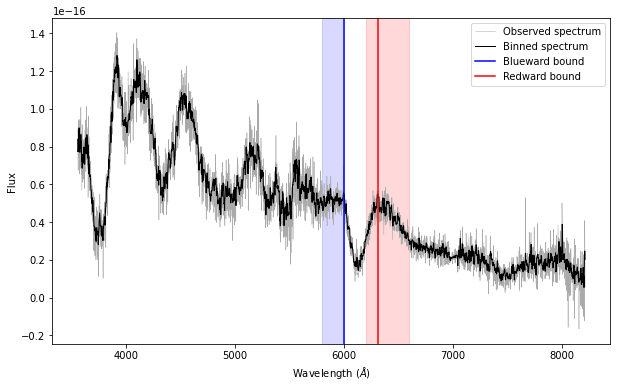

In [9]:
plot_sdss_start_end(1241, 2453636.5, 'pW7')


In [10]:
def plot_sdss_spectrum_measurements(obj_id, time, feat_choice, axis=None):
    """Plot a feature's pseudo equivilent width
    
    Args:
        obj_id (int, str): The Id of the object to load data for
        time      (float): The JD of the observed spectrum
        feat_choice (str): The id of the feature to load data for
        axis       (Axis): Optionally use a pre-existing matplotlib axis
    """ 
    
    if axis is None:
        axis = plt.subplots(figsize=DEFAULT_AXIS_SIZE)[1]
    
    sdss_data = load_data_for_sdss_id(obj_id, time)
    rest_wave = sdss_data['rest_wave']
    rest_flux = sdss_data['rest_flux']
    bin_flux = sdss_data['bin_flux']
    
    feat_data = get_feature_data(obj_id, time, feat_choice)
    feat_start = feat_data['feat_start']
    feat_end = feat_data['feat_end']
    
    flux_start = np.interp(feat_start, rest_wave, bin_flux)
    flux_end = np.interp(feat_end, rest_wave, bin_flux)
        
    # Get wavelength and flux values for just the feature
    i = (feat_start <= rest_wave) & (rest_wave <= feat_end)
    x = rest_wave[i]
    y2 = rest_flux[i]
        
    fit_params = np.polyfit([feat_start, feat_end], [flux_start, flux_end], 1)
    fit_func = np.poly1d(fit_params)
    y = fit_func(x)
 
    axis.plot(rest_wave, rest_flux, color='#AAAAAA', linewidth=.5, label = 'Observed spectrum')
    axis.plot(rest_wave, bin_flux, color='k', linewidth=1, label = 'Binned spectrum')
    axis.fill_between(x, y2, y, color='blue', alpha=.2, label=f'pEW')
    axis.plot(x, y, color='red', label='Pseudo continuum')
    
    axis.axvline(feat_start, color='k', alpha=.3, linestyle='--')
    axis.axvline(feat_end, color='k', alpha=.3, linestyle='--')
    
    axis.legend()
    axis.set_xlabel(r'Wavelength ($\AA$)')
    axis.set_ylabel('Flux')
    

/home/djperrefort/miniconda3/envs/SN-Spectral-Evolution/lib/python3.7/site-packages/ipykernel_launcher.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  # Remove the CWD from sys.path while we load stuff.


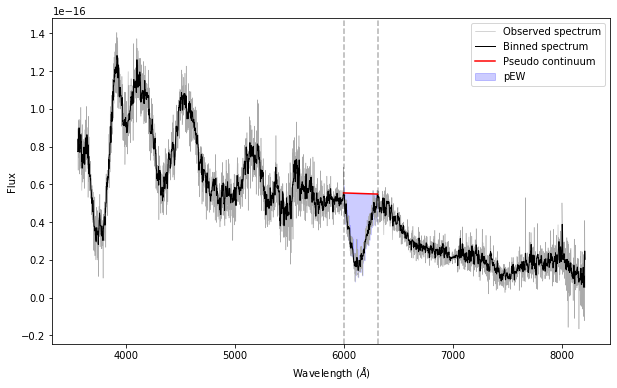

In [11]:
plot_sdss_spectrum_measurements(1241, 2453636.5, 'pW7')


In [12]:
def gaussian(x, N0, mu, sigma):
    """Evaluate a negative gaussian

    f = -depth * e^(-((x - avg)^2) / (2 * std ** 2)) + offset

    Args:
        x    (ndarray): Values to evaluate the gaussian at
        depth  (float): Amplitude of the gaussian
        avg    (float): Average of the gaussian
        std    (float): Standard deviation of the gaussian
        offset (float): Vertical offset

    Returns:
        The evaluated gaussian
    """

    return N0 * np.exp(-0.5 * ((x - mu) / sigma) ** 2)


In [13]:
def plot_sdss_spectrum_gauss(obj_id, time, feat_choice, axis=None):
    """Plot a gaussian fit to the binned flux of a given feature
    
    Args:
        obj_id (int, str): The Id of the object to load data for
        time      (float): The JD of the observed spectrum
        feat_choice (str): The id of the feature to load data for
        axis       (Axis): Optionally use a pre-existing matplotlib axis
    """
        
    if axis is None:
        axis = plt.subplots(figsize=DEFAULT_AXIS_SIZE)[1]
    
    sdss_data = load_data_for_sdss_id(obj_id, time)
    rest_wave = sdss_data['rest_wave']
    rest_flux = sdss_data['rest_flux']
    bin_flux = sdss_data['bin_flux']
    
    feat_data = get_feature_data(obj_id, time, feat_choice)
    feat_start = feat_data['feat_start']
    feat_end = feat_data['feat_end']

    # Get the flux data just for the feature
    i = (rest_wave >= feat_start) & ((rest_wave <= feat_end))
    feat_wave = rest_wave[i]
    feat_flux = rest_flux[i]
    feat_binned = bin_flux[i]
    
    feature = ObservedFeature(feat_wave, feat_flux, feat_binned, FEATURES[feat_choice]['restframe'])
    
    axis.plot(rest_wave, rest_flux, color='#AAAAAA', linewidth=.5, label = 'Observed spectrum')
    axis.plot(rest_wave, bin_flux, color='k', linewidth=1, label = 'Binned spectrum')
    axis.plot(feature.wave, feature.gaussian_fit() * feature.continuum, color='red', label='Gaussian fit')
    
    axis.axvline(feat_start, color='k', alpha=.3, linestyle='--')
    axis.axvline(feat_end, color='k', alpha=.3, linestyle='--')

    axis.legend()
    axis.set_xlabel(r'Wavelength ($\AA$)')
    axis.set_ylabel('Flux')


/home/djperrefort/miniconda3/envs/SN-Spectral-Evolution/lib/python3.7/site-packages/ipykernel_launcher.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  # Remove the CWD from sys.path while we load stuff.


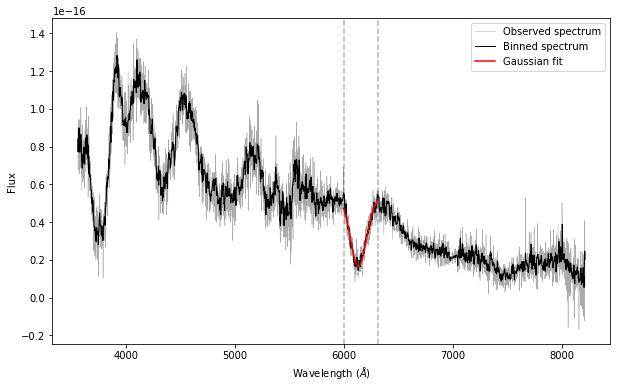

In [14]:
plot_sdss_spectrum_gauss(1241, 2453636.5, 'pW7')


In [15]:
def plot_measurement_process(obj_id, time, feat_choice, xlim=None, ylim=None, figsize=(10, 12)):
    """Plot the feature measurement process
    
    Args:
        obj_id    (int, str): The Id of the object to load data for
        time         (float): The JD of the observed spectrum
        feat_choice    (str): The id of the feature to load data for
        axis          (Axis): Optionally use a pre-existing matplotlib axis
        xlim    (Tuple[int]): The limits of the x axis
        ylim    (Tuple[int]): The limits of the y axis
        figszie (Tuple[int]): The size of the figure
    """

    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex='col', sharey='col', figsize=figsize)
    plot_sdss_start_end(obj_id, time, feat_choice, ax1)
    plot_sdss_spectrum_measurements(obj_id, time, feat_choice, ax2)
    plot_sdss_spectrum_gauss(obj_id, time, feat_choice, ax3)
    
    for ax in (ax1, ax2):
        ax.set_xlabel('')
    
    if xlim:
        ax1.set_xlim(*xlim)
    
    if ylim:
        ax1.set_ylim(*ylim)
    
    iau = s18.load_table('master').to_pandas('CID').loc['1241'].IAUName
    if iau:
        fig.suptitle(f'Spectrum of SN {iau} (CID {obj_id})')
        
    else:
        fig.suptitle(f'Spectrum of CID {obj_id}')
    

/home/djperrefort/miniconda3/envs/SN-Spectral-Evolution/lib/python3.7/site-packages/ipykernel_launcher.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  # Remove the CWD from sys.path while we load stuff.
/home/djperrefort/miniconda3/envs/SN-Spectral-Evolution/lib/python3.7/site-packages/ipykernel_launcher.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  # Remove the CWD from sys.path while we load stuff.
/home/djperrefort/miniconda3/envs/SN-Spectral-Evolution/lib/python3.7/site-packages/ipykernel_launcher.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  # Remove the CWD from sys.path while we load stuff.


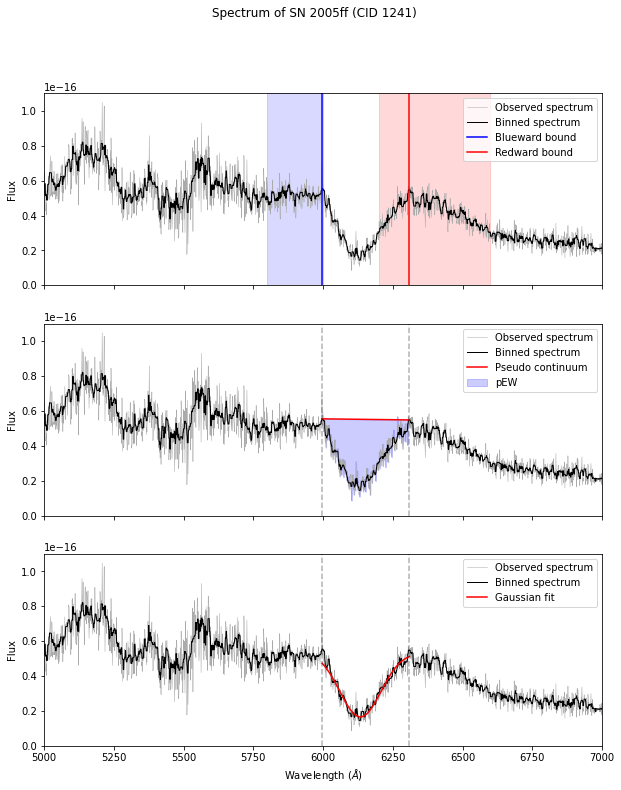

In [16]:
plot_measurement_process(1241, 2453636.5, feat_choice='pW7', xlim=(5000, 7000), ylim=(0, 1.1E-16))
